# Lesson 5b: Recurrent Neural Networks: Categorization

Recurrent Neural Networks (RNNs) can be used in many different ways, such as classification, single-step prediction, and the generation of an entire sequence. 

* **Classification**: the input is a sequence, and the output is a single category - this is the focus of this assignment. (Alternatively, a sequence of categories could be generated, one for each partial sequence as it is processed).

* **Prediction**: the input is a sequence, and the output is a prediction for the next element in the sequence. You will explore this in lesson 5b.

* **Sequence Generation** (Seq-to-Seq): both the input and the output are entire sequences. For example, RNN-based language translation may take in an input sequence (of characters or word tokens) in English, and generate as output a sequence (of characters or word tokens) in French.

RNNs can be used to process inputs that occur naturally in time (such as an audio recording of speech or music represented as a stream of timestamped MIDI messages), but they can also be applied to material that has an order to it, even if it's not necessarly temporal in natures, such as written text (which can be read one character or one word at a time) or even written numbers or math equations (which can be read one digit or symbol at a time, from left to right, for instance.)  This is the problem we investigate today: looking at numbers such as "1423" as a sequence of digits ['1', '4', '2', '3'].

Our problem comes curtosy of Distinguished Professor Douglas R. Hofstadter of Indiana University, author of books such as _Gödel, Escher, Bach: an Eternal Golden Braid_. Hofstadter writes [private communication, shared with permission)]:

---

_Lately, I have been musing about the seeming power of deep neural nets.  They learn to recognize members of all sorts of categories, when those members (and non-members) are fed to them as patterns of symbols or of pixels.  So, how about the following challenges involving the natural numbers?_

* To recognize the even numbers, expressed in base 3.
     (Specifically, 0, 2, 11, 20, 22, 101, 110, 112,...)
* To recognize the multiples of 3, expressed in base 10.
* To recognize the multiples of 9, expressed in base 10.
* To recognize the multiples of 7, expressed in base 10.
* To recognize the multiples of 29, expressed in base 10.

_(I suppose that if a net can learn any particular one of the above list, it can learn all of them.  Just a guess...)_

 _Moving right along, how about the following somewhat harder challenges?_

* To recognize the correct integer additions, expressed either in base 2 or in base 10.  (For example, the string “12+29=41”.)
* To recognize the correct integer multiplications, expressed either in base 2 or in base 10.  (For example, the string “12x29=348”.)

_(The latter of this pair seems significantly harder than the former.)_
     
_And then, of course, the canonical challenge of this sort:_

* To recognize the prime numbers, expressed either in base 2 or in base 10.

_Each of the above challenges involves a number-theoretical category that can easily be described in purely syntactic terms (i.e., as a rule-based pattern of symbols).  It would be trivial to generate millions of examples of such categories mechanically, and then you just feed them to the neural net.  You can also feed the network lots of counterexamples -- marking them, of course, as non-members of the category.  Can a deep neural network learn any of these categories?  All of them?  Some of them?_

---

In this assignment, you will use an RNN to try to solve the divisibility-by-3 problem (the rest are challenges you might want to try in your free time!): 

* **"To recognize the multiples of 3, expressed in base 10."**  Specifically, you must:
    * Design an RNN that takes a sequence of digits as input. 
    * Represent digits in base 10 by using a categorical, one-hot encoding, with one node for each digit from 0 through 9.
    * Train the RNN to categorize a number as True if it is evenly divisible by 3, False otherwise.
    * Test the RNN on a set of previously-unseen numbers, including numbers that are 4 digits long, such as 2225 and 3333.
    * Acheive an accuracy of at least 95% on the test set (report the accuracy in the cell marked below).
    * Answer the questions at the end of this notebook.




# Setup
## Imports

In [40]:
%matplotlib inline
from keras.models import Model, Sequential, load_model
from keras.layers import Input, GRU, LSTM, Dense, Masking, Dropout,Activation, Flatten, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.sequence import pad_sequences
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.layers import Embedding
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import random
from random import shuffle



## Constants

In [41]:
#Set up params for dataset.
DIVISIBILITY_NUMBER = 3         # We want to test for divisilibity by 3.
TRAIN_TEST_SPLIT = 0.7          # Percentage of data in training set
NUM_EXAMPLES_PER_CLASS = 1000      # Generate the first 1000 multiples of 3 for training/testing
                                # Also generate 1000 non-multiples of 3.
NUM_CATEGORIES = 10             # 10 digits
MAX_DIGITS = 5                  # Number of digits allowed in input strings

# Neural net hyperparameters-- just an example. Adjust these as needed.
BATCH_SIZE = 32
NUM_LSTM_NODES = 512  # 10       
DROPOUT = 0.5 
LEARING_RATE = 0.001
NUM_EPOCHS = 500 #500 #50 ####

# TODO: add/modify constants as needed


## Helper functions to generate the dataset of training/testing examples

In [42]:
def generate_example_numbers(base_number=DIVISIBILITY_NUMBER, num_examples_per_class=NUM_EXAMPLES_PER_CLASS):
    """Return a tuple of two lists: (list_of_multiples, list_of_nonmultiples).
    
    For example, ([0, 3, 6, 9, 12, ...2997], [1, 4, 5, 8, 11, 13, 14,...,2999]).
    Each list contains num_examples_per_class elements.
    """
    multiples =[]
    non_multiples = []
    
    for x in range(num_examples_per_class):
        multiples.append(random.randint(1,33333) * base_number)
        non_multiples.append((random.randint(1,33333) * base_number) + 1)
    return (multiples, non_multiples)

#generatedNumbers = generate_example_numbers()
#for x in range(50):
#    print(generatedNumbers[0][x])
#    print(generatedNumbers[1][x])
    

In [43]:
def generate_labels(size_multiples = NUM_EXAMPLES_PER_CLASS, size_non_multiples= NUM_EXAMPLES_PER_CLASS):
    """Return two list of labels one for the True case (multiples) and one for the False case (nonmultiples).
    
    Represent True as 1, False as 0.
    For example, return ([1, 1, 1, 1.....], [0, 0, 0, 0, ....]) with each list the requested size.
    """
    multiples_Label =[]
    non_multiples_Label = []
    
    for x in range(size_multiples):
        multiples_Label.append(1)
        non_multiples_Label.append(0)
    return (multiples_Label, non_multiples_Label)

#generatedLabels = generate_labels()
#for x in range(50):
#    print(generatedLabels[0][x])
#    print(generatedLabels[1][x])


In [44]:
def digit_to_vector(digit):
    """Given a digit from 0-9, return a numpy array representing the digit using a 1-hot encoding.
    keras.utils.to_categorical may be useful.
    """
    encoded = to_categorical(digit) 
    return encoded

#encoded = digit_to_vector(4)
#print(encoded)

In [45]:
def number_to_input_example(number, max_digits=MAX_DIGITS):
    """Given an integer number, return a numpy float array of 0.0s and 1.0s, of the correct shape to feed into the 
    neural net.
    
    For example, if you have a max of 5 digits then you should have a 2D numpy matrix: 5 rows (one for each
    sequence index), and 10 columns (1 for each digit).
    
    In order to train in "batch" mode, the RNN expects every example to have the same shape. So if you have a 2-digit
    number such as "42", you need to pad the example with a "padding" token somehow; for example, "???42", and then
    use keras.layers.Masking to ignore the leading digits. Or just pad with 0s, as in "00042". 
    keras.preprocessing.sequence.pad_sequences can help with this.
    """
    # convert given number to individual digit [123] to [1,2,3]
    intarray = [int(d) for d in str(number)]
    # make list of list
    numlist = list(intarray)
    seqlist = []
    seqlist.append(numlist)
    digit = pad_sequences(seqlist, maxlen=max_digits)
    #print (digit)
    return digit
#number_to_input_example(123456)

def generate_dataset(divisibility_number=DIVISIBILITY_NUMBER, train_test_split=TRAIN_TEST_SPLIT, 
                     num_examples_per_class=NUM_EXAMPLES_PER_CLASS):
    """Generate a dataset ready for training. Returns a list of tuples. Each tuple is of the form
    (input_array, label). The dataset should be shuffled either here or during the training process to
    mix divisile-by-DIVISIBILITY_NUMBER and not-divisible-by-DIVISIBILITY_NUMBER examples.
    The dataset should consist of NUM_EXAMPLES_PER_CLASS positive examples (e.g., 1000 examples of divisible-by-3), and
    also NUM_EXAMPLES_PER_CLASS negative examples (e.g., 1000 examples of not-divisible-by-3).
    """
    
    generatedDataSet = []
    generatedNumbers = generate_example_numbers()
    generatedLabels = generate_labels()
    
    for x in range(NUM_EXAMPLES_PER_CLASS):
        generatedDataSet.append(tuple((generatedNumbers[0][x], generatedLabels[0][x])))
        generatedDataSet.append(tuple((generatedNumbers[1][x], generatedLabels[1][x])))
        
    shuffle(generatedDataSet)
    #for x in range(50):
    #    print(generatedDataSet[x])
    #    print(generatedDataSet[x][0])
    #    print(generatedDataSet[x][1])
        
    return generatedDataSet
        
#generate_dataset()
    


## Helper functions to generate the model

In [46]:
# Build RNN model.
def build_model():
    model = Sequential()
    
    #model.add(Embedding(NUM_CATEGORIES, output_dim=256))
    model.add(Embedding(NUM_CATEGORIES, output_dim=512))

    model.add(LSTM(NUM_LSTM_NODES, dropout=0.3, return_sequences=False, input_shape=(MAX_DIGITS, NUM_CATEGORIES)))  # Use return_sequences=True for multiple hidden layers
    model.add(Dropout(0.5)) 
    #model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(64, activation='relu'))
    

    model.add(Dense(1, activation='sigmoid'))  # Model should return 1 or 0 for divisible/not-divisible
    return model

In [47]:
# Print the model configuration.
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 512)         5120      
_________________________________________________________________
lstm_5 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 2,139,265
Trainable params: 2,138,241
Non-trainable params: 1,024
______________________________________________________________

# Generate dataset and model

In [48]:
data =[]
data = generate_dataset()
X = [d[0] for d in data]
y = [d[1] for d in data]


In [49]:
# TODO: build train/validate datasets.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(X, y, test_size=0.33)
#train_data = ...
#validation_data = ...
#train_inputs = ...
#train_labels = ...
#validation_inputs = ...
#validation_labels = ...

In [50]:
# Compile model
adam = Adam(lr=LEARING_RATE)   # Modify learning algorithm as needed
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])

# Train the model

In [51]:
#TODO: Configure for viewing validation loss/accuracy using the "validation_data" parameter.
#model.fit(train_inputs, train_labels, validation_data=(validation_inputs, validation_labels), batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, shuffle=True, verbose=1)

model.fit(train_inputs, train_labels, validation_data=(validation_inputs, validation_labels), batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, shuffle=True, verbose=1)


Train on 1340 samples, validate on 660 samples
Epoch 1/500
1340/1340 [==============================] - 2s 2ms/step - loss: 0.6932 - acc: 0.4955 - val_loss: 0.6934 - val_acc: 0.4606
Epoch 2/500
1340/1340 [==============================] - 1s 605us/step - loss: 0.6930 - acc: 0.5194 - val_loss: 0.6937 - val_acc: 0.4606
Epoch 3/500
1340/1340 [==============================] - 1s 605us/step - loss: 0.6929 - acc: 0.5194 - val_loss: 0.6941 - val_acc: 0.4606
Epoch 4/500
1340/1340 [==============================] - 1s 606us/step - loss: 0.6928 - acc: 0.5194 - val_loss: 0.6945 - val_acc: 0.4606
Epoch 5/500
1340/1340 [==============================] - 1s 608us/step - loss: 0.6927 - acc: 0.5194 - val_loss: 0.6948 - val_acc: 0.4606
Epoch 6/500
1340/1340 [==============================] - 1s 609us/step - loss: 0.6926 - acc: 0.5194 - val_loss: 0.6950 - val_acc: 0.4606
Epoch 7/500
1340/1340 [==============================] - 1s 606us/step - loss: 0.6926 - acc: 0.5194 - val_loss: 0.6952 - val_acc: 0.4

1340/1340 [==============================] - 1s 594us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6971 - val_acc: 0.4606
Epoch 61/500
1340/1340 [==============================] - 1s 593us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 62/500
1340/1340 [==============================] - 1s 599us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6970 - val_acc: 0.4606
Epoch 63/500
1340/1340 [==============================] - 1s 595us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 64/500
1340/1340 [==============================] - 1s 594us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6971 - val_acc: 0.4606
Epoch 65/500
1340/1340 [==============================] - 1s 596us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 66/500
1340/1340 [==============================] - 1s 593us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 67/500
1340/1340 [=======================

1340/1340 [==============================] - 1s 668us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6968 - val_acc: 0.4606
Epoch 120/500
1340/1340 [==============================] - 1s 677us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6971 - val_acc: 0.4606
Epoch 121/500
1340/1340 [==============================] - 1s 693us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6970 - val_acc: 0.4606
Epoch 122/500
1340/1340 [==============================] - 1s 626us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6970 - val_acc: 0.4606
Epoch 123/500
1340/1340 [==============================] - 1s 606us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6971 - val_acc: 0.4606
Epoch 124/500
1340/1340 [==============================] - 1s 614us/step - loss: 0.6925 - acc: 0.5194 - val_loss: 0.6970 - val_acc: 0.4606
Epoch 125/500
1340/1340 [==============================] - 1s 607us/step - loss: 0.6925 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 126/500
1340/1340 [================

1340/1340 [==============================] - 1s 607us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6970 - val_acc: 0.4606
Epoch 179/500
1340/1340 [==============================] - 1s 611us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 180/500
1340/1340 [==============================] - 1s 605us/step - loss: 0.6925 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 181/500
1340/1340 [==============================] - 1s 605us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6971 - val_acc: 0.4606
Epoch 182/500
1340/1340 [==============================] - 1s 607us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6971 - val_acc: 0.4606
Epoch 183/500
1340/1340 [==============================] - 1s 610us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 184/500
1340/1340 [==============================] - 1s 614us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 185/500
1340/1340 [================

1340/1340 [==============================] - 1s 602us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 238/500
1340/1340 [==============================] - 1s 597us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6970 - val_acc: 0.4606
Epoch 239/500
1340/1340 [==============================] - 1s 591us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 240/500
1340/1340 [==============================] - 1s 609us/step - loss: 0.6925 - acc: 0.5194 - val_loss: 0.6967 - val_acc: 0.4606
Epoch 241/500
1340/1340 [==============================] - 1s 643us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 242/500
1340/1340 [==============================] - 1s 624us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6968 - val_acc: 0.4606
Epoch 243/500
1340/1340 [==============================] - 1s 594us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6971 - val_acc: 0.4606
Epoch 244/500
1340/1340 [================

Epoch 296/500
1340/1340 [==============================] - 1s 595us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6970 - val_acc: 0.4606
Epoch 297/500
1340/1340 [==============================] - 1s 597us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6971 - val_acc: 0.4606
Epoch 298/500
1340/1340 [==============================] - 1s 591us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 299/500
1340/1340 [==============================] - 1s 592us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 300/500
1340/1340 [==============================] - 1s 597us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6968 - val_acc: 0.4606
Epoch 301/500
1340/1340 [==============================] - 1s 599us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6968 - val_acc: 0.4606
Epoch 302/500
1340/1340 [==============================] - 1s 594us/step - loss: 0.6925 - acc: 0.5194 - val_loss: 0.6972 - val_acc: 0.4606
Epoch 303/500
1340/1340 [==

Epoch 355/500
1340/1340 [==============================] - 1s 608us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 356/500
1340/1340 [==============================] - 1s 606us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6971 - val_acc: 0.4606
Epoch 357/500
1340/1340 [==============================] - 1s 608us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6970 - val_acc: 0.4606
Epoch 358/500
1340/1340 [==============================] - 1s 608us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6970 - val_acc: 0.4606
Epoch 359/500
1340/1340 [==============================] - 1s 606us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 360/500
1340/1340 [==============================] - 1s 603us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6971 - val_acc: 0.4606
Epoch 361/500
1340/1340 [==============================] - 1s 610us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6971 - val_acc: 0.4606
Epoch 362/500
1340/1340 [==

Epoch 414/500
1340/1340 [==============================] - 1s 610us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6970 - val_acc: 0.4606
Epoch 415/500
1340/1340 [==============================] - 1s 609us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6970 - val_acc: 0.4606
Epoch 416/500
1340/1340 [==============================] - 1s 615us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6970 - val_acc: 0.4606
Epoch 417/500
1340/1340 [==============================] - 1s 610us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6968 - val_acc: 0.4606
Epoch 418/500
1340/1340 [==============================] - 1s 611us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6970 - val_acc: 0.4606
Epoch 419/500
1340/1340 [==============================] - 1s 610us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6970 - val_acc: 0.4606
Epoch 420/500
1340/1340 [==============================] - 1s 609us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 421/500
1340/1340 [==

Epoch 473/500
1340/1340 [==============================] - 1s 597us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 474/500
1340/1340 [==============================] - 1s 598us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6971 - val_acc: 0.4606
Epoch 475/500
1340/1340 [==============================] - 1s 596us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6970 - val_acc: 0.4606
Epoch 476/500
1340/1340 [==============================] - 1s 594us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 477/500
1340/1340 [==============================] - 1s 592us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6969 - val_acc: 0.4606
Epoch 478/500
1340/1340 [==============================] - 1s 595us/step - loss: 0.6925 - acc: 0.5194 - val_loss: 0.6971 - val_acc: 0.4606
Epoch 479/500
1340/1340 [==============================] - 1s 599us/step - loss: 0.6924 - acc: 0.5194 - val_loss: 0.6970 - val_acc: 0.4606
Epoch 480/500
1340/1340 [==

Report your final accuracy on the validation dataset below.

In [52]:

scores = model.evaluate(validation_inputs, validation_labels, verbose=1)
print("loss: %.2f%%" % (scores[0]*100))
print("accuracy: %.2f%%" % (scores[1]*100))

660/660 [==============================] - 0s 104us/step
loss: 69.68%
accuracy: 46.06%


#TODO: accuracy = ??%


## Examine model outputs

In [53]:
# Examine the outputs of the model on some test data.
[model.predict(np.expand_dims(validation_inputs[i], 0)) for i in range(10)]

[array([[0.4810968]], dtype=float32),
 array([[0.4810968]], dtype=float32),
 array([[0.4810968]], dtype=float32),
 array([[0.4810968]], dtype=float32),
 array([[0.4810968]], dtype=float32),
 array([[0.4810968]], dtype=float32),
 array([[0.4810968]], dtype=float32),
 array([[0.4810968]], dtype=float32),
 array([[0.4810968]], dtype=float32),
 array([[0.4810968]], dtype=float32)]

In [54]:
# Plot some results
results = []
lo = 0
hi = 1000
rng = range(lo,hi)
for num in rng:
    # Hint: to run on a single example, you can use "np.expand_dims" to add an extra 
    # dimension to a 2D array, in order to make a "batch" of 1.
    #
    # TODO something like this:
    #print(num)
    results.append(model.predict(number_to_input_example(num))[0][0])
    
#testnum = 234567
#model.predict(number_to_input_example(testnum))[0][0]
#[model.predict(np.expand_dims(number_to_input_example(testnum))[0][0], 0) for i in range(10)]
#print (results)

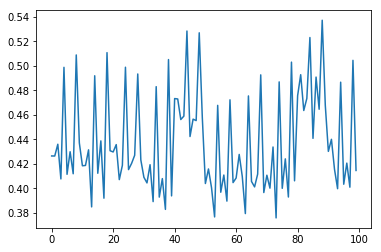

In [55]:
plt.plot(rng[:100], results[:100])
plt.show()

# Further Questions

1) What happens if you give a 5-digit number or a 6-digit number to the trained model, after training on 1-, 2-, 3-, and 4- digit numbers?

2) Pick another number from Hofstadter's list above, such as 9, 7, or 29. Train a model, and report the accuracy of your results. Did it work or not? Why or why not (your best guess)?

I should work. It should accurately predict for those values. Even though traing has happened for randomlu generated numbers, my gues is that it leans that the number 3 is a facor of 9, but not 29 or 7.

3) Record any other comments/insights from your model training process. What worked well? What caused trouble?

My accuracy was always low. I tried by increasing number of epochs to 250, I tried increasing NUM_LSTM_NODES to 512, but still getting same accuracy.

4) If you didn't have a training algorithm, how would you design a RNN-style system to recognize divisibility by 3?
Ignoring the details of the weights, what kind of state must be carried over from step to step as each digit is read in
successively?

Divisibility rule for number 3 is that sum of the individual digits should be divisible by 3. We should carry the sum of the digits as the state to be carried over.

5) BONUS (hard): Explain how the neural net you trained above works, with evidence from examining the node activations as the net runs. Does it do anything similar to what you would have designed as a human?